In [ ]:
  !nvidia-smi

Thu Aug 27 16:17:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 导入数据

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


这次我们准备使用五个监测站的数据。假定Marylebone Road监测站的数据出现异常，此时我们用Bloomsbury, Eltham, Harlington和N_Kensington的数据来推断Marylebone的数据。注意，与之前多变量预测相同，该实验依旧是多变量预测单变量。分多次预测，实现多变量预测多变量。

In [ ]:
Marylebone_Road=pd.read_csv('/content/drive/My Drive/air_inference/data/Marylebone_Road_clean.csv')
Bloomsbury=pd.read_csv('/content/drive/My Drive/air_inference/data/Bloomsbury_clean.csv')
Eltham=pd.read_csv('/content/drive/My Drive/air_inference/data/Eltham_clean.csv')
Harlington=pd.read_csv('/content/drive/My Drive/air_inference/data/Harlington_clean.csv')
N_Kensington=pd.read_csv('/content/drive/My Drive/air_inference/data/N_Kensington_clean.csv')

In [ ]:
Marylebone_Road.head()

,site,code,date,nox,no2,no,o3,pm2.5,ws,wd,air_temp
0,London Marylebone Road,MY1,2018-01-01 00:00:00,219.745313,81.948282,89.868883,20.680073,10.368619,4.594288,258.053368,5.187445
1,London Marylebone Road,MY1,2018-01-01 01:00:00,221.095446,81.975320,90.731783,20.623365,10.251473,4.602090,257.695571,5.219898
2,London Marylebone Road,MY1,2018-01-01 02:00:00,222.430163,82.046845,91.555615,20.582777,10.169084,4.613062,257.370167,5.255796
3,London Marylebone Road,MY1,2018-01-01 03:00:00,222.483880,81.654154,91.846755,20.745120,10.014187,4.630636,257.105888,5.300848
4,London Marylebone Road,MY1,2018-01-01 04:00:00,221.593263,81.130682,91.607309,20.959725,9.813301,4.661511,256.906359,5.350748


In [ ]:
Marylebone_Road=Marylebone_Road[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Bloomsbury=Bloomsbury[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Eltham=Eltham[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Harlington=Harlington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
N_Kensington=N_Kensington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]

dataset=pd.concat([Marylebone_Road,Bloomsbury])
dataset.head()


,nox,no2,no,o3,pm2.5,ws,wd,air_temp
0,219.745313,81.948282,89.868883,20.680073,10.368619,4.594288,258.053368,5.187445
1,221.095446,81.975320,90.731783,20.623365,10.251473,4.602090,257.695571,5.219898
2,222.430163,82.046845,91.555615,20.582777,10.169084,4.613062,257.370167,5.255796
3,222.483880,81.654154,91.846755,20.745120,10.014187,4.630636,257.105888,5.300848
4,221.593263,81.130682,91.607309,20.959725,9.813301,4.661511,256.906359,5.350748


In [ ]:
Marylebone_Road
Bloomsbury
Eltham
Harlington
N_Kensington

,nox,no2,no,o3,pm2.5,ws,wd,air_temp
0,18.634584,16.685778,1.270981,60.070209,6.872474,4.594288,258.053368,5.187445
1,19.176644,17.122874,1.339436,59.637749,6.795094,4.602090,257.695571,5.219898
2,19.723134,17.548214,1.418449,59.211174,6.717488,4.613062,257.370167,5.255796
3,20.133219,17.844811,1.492463,58.913020,6.621239,4.630636,257.105888,5.300848
4,19.865833,17.747791,1.381354,58.671554,6.515320,4.661511,256.906359,5.350748
...,...,...,...,...,...,...,...,...
17515,58.800669,42.477744,10.645537,3.426733,25.599702,2.322937,122.323683,3.055791
17516,58.908322,42.657677,10.598397,3.370981,25.819725,2.312240,120.287580,3.010667
17517,59.006263,42.836211,10.545836,3.281494,26.037294,2.298849,118.331870,2.968728
17518,59.081172,42.984552,10.497945,3.231871,26.253455,2.292898,116.428207,2.931535


先将每个监测站的columns更名。加上后缀为监测站的首字母

In [ ]:
col_Marylebone=['nox_M','no2_M','no_M','o3_M','pm2.5_M','ws_M','wd_M','air_temp_M']
col_Bloomsbury=['nox_B','no2_B','no_B','o3_B','pm2.5_B','ws_B','wd_B','air_temp_B']
col_Eltham=['nox_E','no2_E','no_E','o3_E','pm2.5_E','ws_E','wd_E','air_temp_E']
col_Harlington=['nox_H','no2_H','no_H','o3_H','pm2.5_H','ws_H','wd_H','air_temp_H']
col_N_Kensington=['nox_N','no2_N','no_N','o3_N','pm2.5_N','ws_N','wd_N','air_temp_N']

Marylebone_Road.columns=col_Marylebone
Bloomsbury.columns=col_Bloomsbury
Eltham.columns=col_Eltham
Harlington.columns=col_Harlington
N_Kensington.columns=col_N_Kensington

接下来将所有监测站的数据拼接起来

In [ ]:
dataset=Bloomsbury.join(Marylebone_Road)
dataset=dataset.join(Eltham)
dataset=dataset.join(Harlington)
dataset=dataset.join(N_Kensington)
dataset.head()


,nox_B,no2_B,no_B,o3_B,pm2.5_B,ws_B,wd_B,air_temp_B,nox_M,no2_M,no_M,o3_M,pm2.5_M,ws_M,wd_M,air_temp_M,nox_E,no2_E,no_E,o3_E,pm2.5_E,ws_E,wd_E,air_temp_E,nox_H,no2_H,no_H,o3_H,pm2.5_H,ws_H,wd_H,air_temp_H,nox_N,no2_N,no_N,o3_N,pm2.5_N,ws_N,wd_N,air_temp_N
0,38.719371,27.599582,7.252141,47.360318,7.497625,4.598855,257.279906,5.378717,219.745313,81.948282,89.868883,20.680073,10.368619,4.594288,258.053368,5.187445,10.387007,7.380368,1.960881,59.104229,10.931926,4.508552,256.806923,5.348268,25.652376,17.162654,5.536853,58.319162,4.669857,6.536290,254.682024,4.977652,18.634584,16.685778,1.270981,60.070209,6.872474,4.594288,258.053368,5.187445
1,38.976582,27.836512,7.265368,47.042127,7.449653,4.603798,257.009139,5.412134,221.095446,81.975320,90.731783,20.623365,10.251473,4.602090,257.695571,5.219898,10.823717,7.652696,2.068089,58.843670,10.720061,4.498159,256.500375,5.379024,26.603729,17.836684,5.717718,57.659575,4.672704,6.554847,254.312810,5.012679,19.176644,17.122874,1.339436,59.637749,6.795094,4.602090,257.695571,5.219898
2,39.251382,28.072885,7.290429,46.715825,7.416401,4.621557,256.762603,5.453970,222.430163,82.046845,91.555615,20.582777,10.169084,4.613062,257.370167,5.255796,11.238689,7.897627,2.178986,58.579590,10.543322,4.510796,256.218836,5.420729,27.500740,18.461178,5.895449,57.038377,4.669182,6.579388,254.014423,5.051040,19.723134,17.548214,1.418449,59.211174,6.717488,4.613062,257.370167,5.255796
3,37.985254,27.997451,6.513879,46.400863,7.358787,4.636919,256.538550,5.502388,222.483880,81.654154,91.846755,20.745120,10.014187,4.630636,257.105888,5.300848,11.546266,8.070745,2.266678,58.360156,10.361331,4.524491,255.957051,5.467779,28.379700,19.068324,6.072721,56.435795,4.654887,6.636912,253.861244,5.099631,20.133219,17.844811,1.492463,58.913020,6.621239,4.630636,257.105888,5.300848
4,38.973919,28.512513,6.822754,46.033610,7.302818,4.658491,256.342472,5.554477,221.593263,81.130682,91.607309,20.959725,9.813301,4.661511,256.906359,5.350748,11.794165,8.191950,2.349305,58.183813,10.154809,4.533285,255.699470,5.517365,29.266844,19.683219,6.250279,55.827704,4.636542,6.716429,253.903225,5.156423,19.865833,17.747791,1.381354,58.671554,6.515320,4.661511,256.906359,5.350748


# 多站点多变量进行预测

In [ ]:
var_origin=dataset.values

数据进行归一化操作

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(var_origin)

将数据转为cuda类型

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
var= torch.FloatTensor(scaled).to(device)

划分训练集，验证集和测试集

In [ ]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

我们的验证集合测试集都取10%

In [ ]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

查看长度

In [ ]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 14016 , 1752 , 1752



取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [ ]:
train_window = 240
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 13776


注意，与上面创建train_data的sequence不同，验证集数据(实验是96个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [ ]:
def create_val_sequence(train_data,val_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq ,val_label))

    return inout_seq

val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


 此时的label的shape是[1,40]。注意，真正的label只有这40个值中的前五个

In [ ]:
val_inout_seq[0][1].shape

torch.Size([1, 40])

In [ ]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=torch.cat((train_data,val_data))   #先将训练集和测试集合并
    temp=torch.cat((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq ,test_label))

    return inout_seq

test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


# 定义LSTM

这次的数据的维度为40维

In [ ]:
train_data.shape

torch.Size([14016, 40])

In [1]:
from torch import nn
import torch.nn.functional as F
import torch.nn.init as init
class LSTMwithAttention(nn.Module):
    def __init__(self,input_size=40,hidden_layer_size=50,output_size=1,num_layers=2):
        super().__init__()
        self.input_size=input_size
        self.hidden_layer_size=hidden_layer_size
        self.num_layers=num_layers
        self.batch_size=1    #注意，该实验的batch_size都为1


        self.conv1d=nn.Conv1d(in_channels=40,out_channels =20, kernel_size = 2)
        self.lstm=nn.LSTM(20,hidden_layer_size,num_layers,dropout=0.2)

        self.linear1=nn.Linear(self.hidden_layer_size,self.hidden_layer_size)
        self.linear2=nn.Linear(self.hidden_layer_size,output_size)
        self.linear=nn.Linear(self.hidden_layer_size,output_size)
        init_rnn(self.lstm,'xavier')
        self.dropout=nn.Dropout(0.5)
        self.attn_weights=None


    def attention_net(self, lstm_output, final_state):

        lstm_output = lstm_output.permute(1, 0, 2)
        hidden = final_state.view(-1,self.hidden_layer_size,self.num_layers)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]

        soft_attn_weights = torch.tanh(self.attn_weights)

        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights).squeeze(2)
        return context # context : [batch_size, n_hidden * num_directions(=2)]

        
    def forward(self,input_seq):
        
        input_seq=input_seq.unsqueeze(0).permute(0,2,1)
        input_seq=self.conv1d(input_seq)

        input_seq=input_seq.permute(0,2,1)
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]),1,20))
        attn_output = self.attention_net(lstm_out,self.hidden_cell[0])
        out=self.linear1(attn_output.view(-1,self.hidden_layer_size))
        out=torch.tanh(out)
        predictions = self.linear2(out)

        return predictions[-1]


#设定初始化
def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / math.sqrt(x.hidden_size)
                    init.normal_(getattr(x, w), .0, stdv)
                else:
                    raise ValueError


# 模型训练准备

与之前一样，分别多nox,no2,no,o3和pm2.5进行预测

In [ ]:
import copy

epochs=5


#为了实现多变量预测多个单变量，我这里用了五个LSTM模型
model_nox=LSTMwithAttention().to(device)
model_no2=LSTMwithAttention().to(device)
model_no=LSTMwithAttention().to(device)
model_o3=LSTMwithAttention().to(device)
model_pm25=LSTMwithAttention().to(device)

loss_function=nn.MSELoss()
optimizer_nox = torch.optim.SGD(model_nox.parameters(), lr=0.004,momentum=0.2, weight_decay=6e-4)
optimizer_no2 = torch.optim.SGD(model_no2.parameters(), lr=0.004,momentum=0.4, weight_decay=6e-4)
optimizer_no = torch.optim.SGD(model_no.parameters(), lr=0.004,momentum=0.3, weight_decay=6e-4)
optimizer_o3 = torch.optim.SGD(model_o3.parameters(), lr=0.004,momentum=0.2, weight_decay=6e-4)
optimizer_pm25 = torch.optim.SGD(model_pm25.parameters(), lr=0.004,momentum=0.2, weight_decay=6e-4)


attr_dic={
    'nox':model_nox,
    'no2':model_no2,
    'no':model_no,
    'o3':model_o3,
    'pm2.5':model_pm25
}

index_dic={
    'nox':0,
    'no2':1,
    'no':2,
    'o3':3,
    'pm2.5':4
    
}

optimizer_dic={
    'nox':optimizer_nox,
    'no2':optimizer_no2,
    'no':optimizer_no,
    'o3':optimizer_o3,
    'pm2.5':optimizer_pm25
}

loss_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

loss_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_train_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}

value_val_dic={
    'nox':[],
    'no2':[],
    'no':[],
    'o3':[],
    'pm2.5':[]
}


In [ ]:
def train_model(attr,model):
  model.train()
  print('训练',attr,'模型')
  for i in range(epochs):
    #train
    add=0
    for seq,label in train_inout_seq:   
        optimizer_dic[attr].zero_grad()
        label=label.to(device)
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),torch.zeros(2, 1, model.hidden_layer_size).to(device))
        
        y_pred = model(seq)

        if(i==epochs-1):  #对最后一次epoch的值进行记录
          value_train_dic[attr].append(y_pred)

        single_loss = loss_function(y_pred[0], label[0,index_dic[attr]])   #这里只预测label[attr]的数值，即某个单一的空气污染物
        add+=single_loss
        single_loss .backward()
        optimizer_dic[attr].step()
    loss_train=add/len(train_inout_seq)
    loss_train_dic[attr].append(loss_train)


    #val
    add=0 
    t=0

    val_inputs=train_data[-train_window:]
    fut_pred = len(val_data)

    for seq,label in val_inout_seq:
      with torch.no_grad():
        seq = val_inputs[-train_window:].to(device)
        label=label.to(device)
        y_pred=model(seq)
        single_loss=loss_function(y_pred[0],label[0,index_dic[attr]])  

        add+=single_loss

        if(i==epochs):  #对最后一次epoch的值进行记录
          value_val_dic[attr].append(y_pred)

        temp=copy.deepcopy(val_data[t])
        temp[index_dic[attr]]=y_pred
        temp=temp.view(1,-1)
        
        val_inputs=torch.cat((val_inputs,temp),0)
        t+=0

    loss_val=add/len(val_inout_seq)
    loss_val_dic[attr].append(loss_val)

    print(f'epoch: {i:3}  train_loss:{loss_train:10.8f} val_loss:{loss_val:10.8f}')
  print('----------------------')

In [ ]:
def test_model(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = len(test_data)
  test_list=[]
  test_results=copy.deepcopy(test_data)

  # model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i]).view(1,-1)
          # temp[index_dic[attr]]=y_pred
          # temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred




  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))




  x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):,attr+'_B'].values,color="red",label='real value')
  plt.plot(actual_predictions[:,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):,attr+'_B'].values
  y_pred=actual_predictions[:,index_dic[attr]]

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

  y_pred=pd.DataFrame(y_pred)
  y_pred.to_csv("/content/drive/My Drive/air_inference/result/attention_"+attr+".csv",header = None, index = None)

下面的函数用于预测未来96小时的情况

In [ ]:
def predict_future(attr,model):
  temp=torch.cat((train_data,val_data))
  test_inputs=temp[-train_window:,:]

  fut_pred = 96
  test_list=[]
  test_results=copy.deepcopy(test_data)

  model.eval()

  for i in range(fut_pred):
      seq = test_inputs[-train_window:].to(device)
      with torch.no_grad():
          model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          y_pred=model(seq)
          temp=copy.deepcopy(test_data[i])
          temp[index_dic[attr]]=y_pred
          temp=temp.view(1,-1)
          test_inputs=torch.cat((test_inputs,temp),0)
          test_results[i]=y_pred




  actual_predictions = scaler.inverse_transform(np.array(test_results.cpu()))





  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr+'_B'].values,color="red",label='real value')
  plt.plot(actual_predictions[:fut_pred,index_dic[attr]],label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)

  y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr+'_B'].values
  y_pred=actual_predictions[:fut_pred,index_dic[attr]]

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))

  y_pred=pd.DataFrame(y_pred)

  y_pred.to_csv('/content/drive/My Drive/air_inference/result24/attention'+attr+'.csv',index=False)

# 开始训练

In [ ]:
%%time
train_model('nox',model_nox)

训练 nox 模型
epoch:   0  train_loss:0.00034260 val_loss:0.05305503
epoch:   1  train_loss:0.00031121 val_loss:0.05249328
epoch:   2  train_loss:0.00028994 val_loss:0.05228006
epoch:   3  train_loss:0.00026491 val_loss:0.05245958
epoch:   4  train_loss:0.00023687 val_loss:0.05222928
----------------------
CPU times: user 20min 36s, sys: 6.42 s, total: 20min 43s
Wall time: 20min 47s


mse:  515.0450108045877
mae:  18.788251828061007


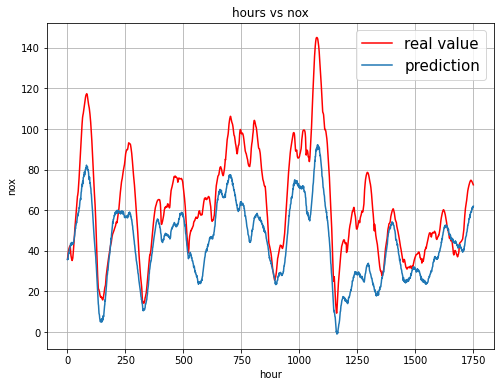

In [ ]:
test_model('nox',model_nox)

mse:  572.6265101794039
mae:  18.763797274980625


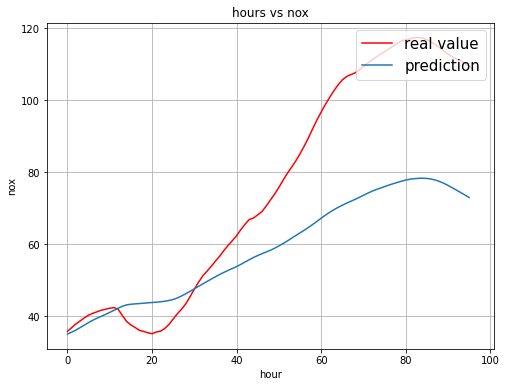

In [ ]:
predict_future('nox',model_nox)

In [ ]:
%%time
train_model('no2',model_no2)

训练 no2 模型
epoch:   0  train_loss:0.00040018 val_loss:0.08028214
epoch:   1  train_loss:0.00026284 val_loss:0.07468236
epoch:   2  train_loss:0.00020007 val_loss:0.07320442
epoch:   3  train_loss:0.00017805 val_loss:0.07054795
epoch:   4  train_loss:0.00020342 val_loss:0.06984508
----------------------
CPU times: user 20min 51s, sys: 6.25 s, total: 20min 58s
Wall time: 21min 2s


mse:  167.1912215853781
mae:  11.319692062686451


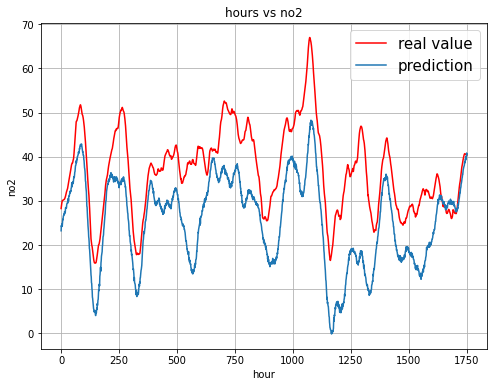

In [ ]:
test_model('no2',model_no2)

mse:  44.573215462171476
mae:  6.2045390449292634


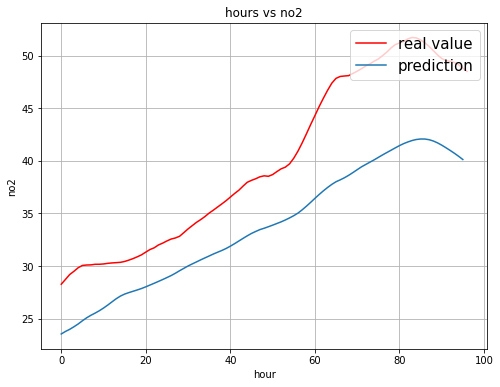

In [ ]:
predict_future('no2',model_no2)

In [ ]:
%%time
train_model('no',model_no)

训练 no 模型
epoch:   0  train_loss:0.00021928 val_loss:0.03156358
epoch:   1  train_loss:0.00021559 val_loss:0.03140092
epoch:   2  train_loss:0.00021388 val_loss:0.03153671
epoch:   3  train_loss:0.00020603 val_loss:0.03133287
epoch:   4  train_loss:0.00019807 val_loss:0.03124058
----------------------
CPU times: user 20min 34s, sys: 6.53 s, total: 20min 41s
Wall time: 20min 46s


mse:  117.91268963591345
mae:  8.726190519308876


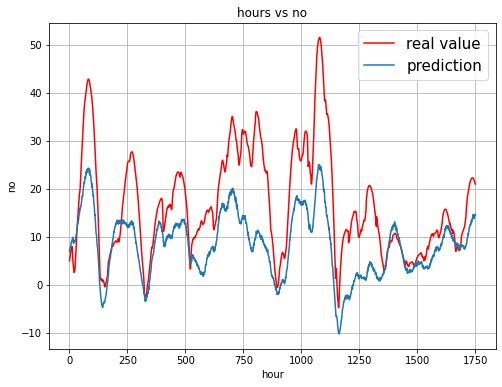

In [ ]:
test_model('no',model_no)

mse:  167.71104172033515
mae:  10.37248849574092


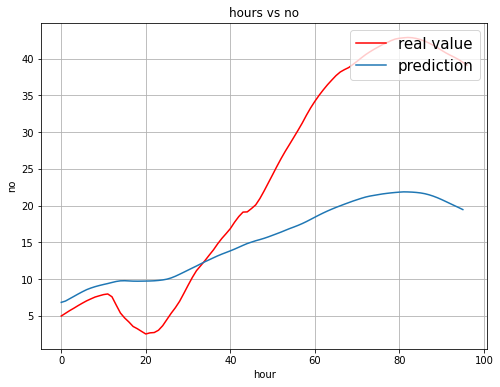

In [ ]:
predict_future('no',model_no)

In [ ]:
%%time
train_model('o3',model_o3)

训练 o3 模型
epoch:   0  train_loss:0.00020181 val_loss:0.07171986
epoch:   1  train_loss:0.00022290 val_loss:0.07398169


In [ ]:
test_model('o3',model_o3)

In [ ]:
predict_future('o3',model_o3)

In [ ]:
%%time
train_model('pm2.5',model_pm25)

训练 pm2.5 模型
epoch:   0  train_loss:0.00047169 val_loss:0.02479235
epoch:   1  train_loss:0.00028211 val_loss:0.02550243
epoch:   2  train_loss:0.00019098 val_loss:0.02392089
epoch:   3  train_loss:0.00012745 val_loss:0.02500652
epoch:   4  train_loss:0.00011120 val_loss:0.02553888
----------------------
CPU times: user 20min 50s, sys: 6.33 s, total: 20min 57s
Wall time: 21min 2s


mse:  7.5193666373158665
mae:  2.3347578356197425


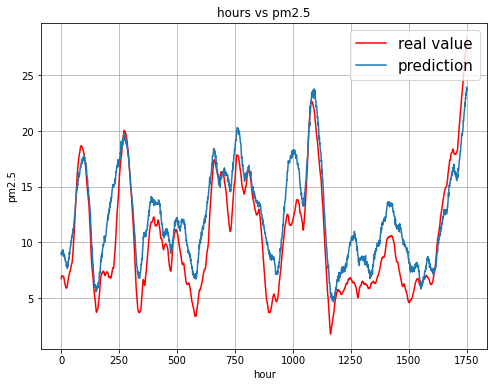

In [ ]:
test_model('pm2.5',model_pm25)

mse:  3.9041684242596566
mae:  1.860136937246324


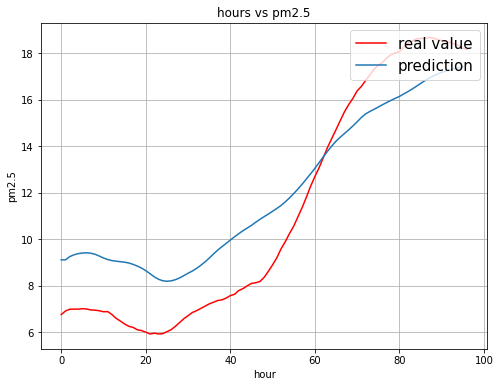

In [ ]:
predict_future('pm2.5',model_pm25)

In [ ]:
# def train_model_val(attr,model):
#   model.train()
#   print('训练',attr,'模型')
#   for i in range(epochs):
#     #train
#     add=0
#     for seq,label in val_inout_seq:   
#         optimizer_dic[attr].zero_grad()
#         seq=seq.to(device)
#         label=label.to(device)
#         model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),torch.zeros(2, 1, model.hidden_layer_size).to(device))
#         # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),torch.zeros(1, 1, model.hidden_layer_size).to(device))
        
#         y_pred = model(seq)

#         # if(i==epochs-1):  #对最后一次epoch的值进行记录
#         #   value_train_dic[attr].append(y_pred)

#         single_loss = loss_function(y_pred[0], label[0,index_dic[attr]])   #这里只预测label[attr]的数值，即某个单一的空气污染物
#         add+=single_loss
#         single_loss .backward()
#         optimizer_dic[attr].step()
#     loss_train=add/len(train_inout_seq)
#     # loss_train_dic[attr].append(loss_train)

In [ ]:
# train_model_val('nox',model_nox)